# Solution Gradient Vanishing / Exploding
- Change activation function
- careful Initialization
- Small learning rate
- Batch Normalization : Stable 

# Internal Covariate Shift

- ICS makes Gradient Vanishing / Exploding
- Train dataset dist is different to test dataset
- Deepen layer makes each distribution skewing
- Batch Normalization is a solution for ICS

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data', train=True, transform=transforms.ToTensor())
mnist_test = dsets.MNIST(root='MNIST_data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [5]:
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [6]:
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                              linear2, bn2, relu,
                              linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [7]:
criterion = torch.nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [8]:
train_losses =  []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

for epoch in range(training_epochs):
    bn_model.train()
    
    for X,Y in train_loader:
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)
        
        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()
        
        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()
        
    with torch.no_grad():
        bn_model.eval()
        
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X,Y) in enumerate(train_loader):
            X = X.view(-1, 28*28).to(device)
            Y = Y.to(device)
            
            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()
            
        bn_loss, bn_acc = bn_loss / train_total_batch, bn_acc / train_total_batch 
        nn_loss, nn_acc = nn_loss / train_total_batch, nn_acc / train_total_batch
        
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print('[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' \
              % ((epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()
            
        bn_loss, bn_acc = bn_loss / test_total_batch, bn_acc / test_total_batch
        nn_loss, nn_acc = nn_loss / test_total_batch, nn_acc / test_total_batch
        
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print('[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' 
              % ((epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))        

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.12842(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.17126(nn_acc:0.95)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.13840(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.16719(nn_acc:0.95)
[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10446(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.15566(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12723(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.17388(nn_acc:0.95)
[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.08780(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.16585(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11090(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.21209(nn_acc:0.95)
[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07054(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.14046(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09361(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17888(nn_acc:0.95)
[Epoch 5-TRAIN] Batchnor

In [11]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]
    
    plt.figure(figsize=(5,10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

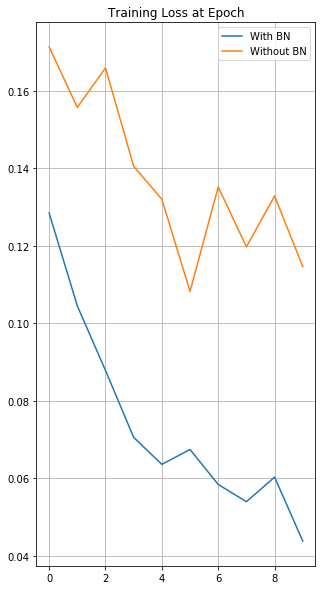

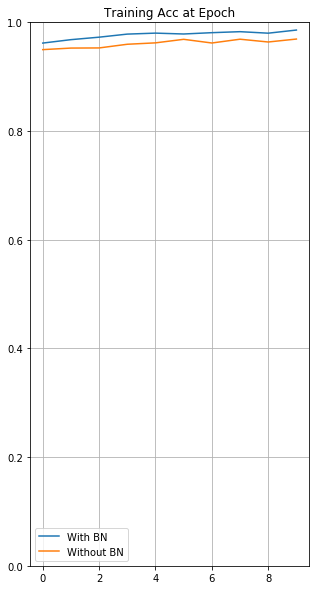

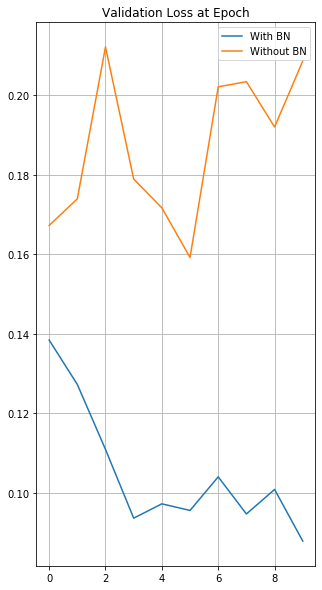

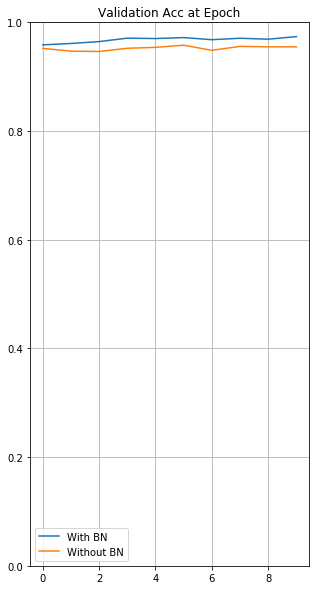

In [12]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')